# Load Data

In [4]:
# Imports
# from settings import *
# import analyze_cascade
import datetime
import pandas as pd
import numpy as np
from itertools import groupby
from collections import Counter
from random import shuffle
from random import choices
import math

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import LSTM, Input, Dense
from keras.layers import concatenate as kerasconc

import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

Using TensorFlow backend.


In [5]:
metadata_file = '/Users/jaspermeijering/Google Drive/a Study/EPA Study Abroad - Carnegie Mellon University/Courses/CMU - 95845 - Applied Analytics The Machine Learning Pipeline/Machine Learning Pipeline Final Project/Data/FalseNews_Code_Data/data/metadata_anon.txt'

In [6]:
# Read meta data 
fin = open(metadata_file,'r')
lines = fin.readlines()
fin.close()
cascade_id2metadata={}
for line in lines:
    line = line.replace('\n','')
    item = eval(line)
    cascade_id2metadata[item[0]] = item[1]

## Descriptives of dynamic measures

### Static measures

In [7]:
# Get static measures
cid = []
veracity = []
virality = []
depth = []
breadth = []
size = []
verified = []
nfollowers = []
nfollowees = []
engagement = []
category = []
for cascade,metadata in cascade_id2metadata.items():
    if metadata['virality'] is not None: 
        cid.append(cascade)
        veracity.append(metadata['veracity'])
        virality.append(metadata['virality'])
        depth.append(metadata['depth'])
        breadth.append(metadata['max_breadth'])
        size.append(metadata['size'])
        verified.append(metadata['verified_list'][0])
        nfollowers.append(metadata['num_followers_list'][0])
        nfollowees.append(metadata['num_followees_list'][0])
        engagement.append(metadata['engagement_list'][0])
        category.append(metadata['rumor_category'])

# Convert to data frame
static = pd.DataFrame({'cid': cid,
                       'veracity': veracity,
                       'virality': virality,
                       'depth': depth,
                       'breadth': breadth,
                       'size': size,
                       'verified': verified,
                       'nfollowers': nfollowers,
                       'nfollowees': nfollowees,
                       'engangement': engagement,
                       'category': category})

# Inspect
static.head(5)

,breadth,category,cid,depth,engangement,nfollowees,nfollowers,size,veracity,verified,virality
0,10703,Viral Photos/Stories/Urban Legends,106998,11,25.799399,186.0,672.0,23228,MIXED,False,4.003857
1,11783,Science/Nature/Tech/Food/Health,106999,9,10.811974,313.0,380.0,14827,MIXED,False,2.535338
2,6504,Viral Photos/Stories/Urban Legends,107000,13,15.395237,518.0,504.0,14129,MIXED,False,4.019705
3,5772,Viral Photos/Stories/Urban Legends,107001,8,3.140842,189.0,228.0,9972,MIXED,False,3.271008
4,6041,Viral Photos/Stories/Urban Legends,107002,8,5.160261,174.0,110.0,9526,MIXED,False,3.115942


### Dynamic measures

In [10]:
len_depth2time = []
len_num_followees_list = []
len_depth2uu = []
len_uu2time = []
len_depth2breadth = []
for cascade,metadata in cascade_id2metadata.items():
    if metadata['virality'] is not None: 
        len_depth2time.append(len(metadata['depth2time'].keys()))
        len_num_followees_list.append(len(metadata['num_followees_list']))
        len_depth2uu.append(len(metadata['depth2uu'].keys()))
        len_uu2time.append(len(metadata['uu2time'].keys()))
        len_depth2breadth.append(len(metadata['depth2breadth'].keys()))
    
# Convert to data frame
dynamic_len = pd.DataFrame({'depth2time ': len_depth2time, 
                           'num_followees_list': len_num_followees_list, 
                           'depth2uu': len_depth2uu, 
                           'uu2time': len_uu2time, 
                           'depth2breadth': len_depth2breadth})

# # Get summary
dynamic_len.describe(percentiles = [0.25, 0.5, 0.75, 1])
    

,depth2breadth,depth2time,depth2uu,num_followees_list,uu2time
count,42081.000000,42081.000000,42081.000000,42081.000000,42081.000000
mean,1.707707,1.707707,1.707707,93.878829,93.878829
std,1.319555,1.319555,1.319555,950.694376,950.694376
min,1.000000,1.000000,1.000000,2.000000,2.000000
25%,1.000000,1.000000,1.000000,2.000000,2.000000
50%,1.000000,1.000000,1.000000,4.000000,4.000000
75%,2.000000,2.000000,2.000000,9.000000,9.000000
100%,24.000000,24.000000,24.000000,46895.000000,46895.000000
max,24.000000,24.000000,24.000000,46895.000000,46895.000000


## Create LSTM data

### Get dynamic data

In [11]:
# Function to get expression of each item in a dictionary entry
def get_expression_list(entry):
    expression = []
    for i in entry.keys():
        expression.append(float(entry[i]))
    return expression

# Convert y to classification
def veracity_to_categorical(v):
    if v == 'FALSE':
        vbin = [1,0,0]
    elif v == 'MIXED':
        vbin = [0,1,0]
    elif v == 'TRUE':
        vbin = [0,0,1]
    else:
        vbin = None
    return vbin

# Get data in list format
data = []
for cascade,metadata in cascade_id2metadata.items():
    if metadata['virality'] is not None:       
        # Get depth
        depth2time = get_expression_list(metadata['depth2time'])
        depth2uu = get_expression_list(metadata['depth2uu'])
        depth2breadth = get_expression_list(metadata['depth2breadth']) 
        veracity = veracity_to_categorical(metadata['veracity'])
        data_id = []
        for time, uu, breadth in zip(depth2time, depth2uu, depth2breadth):
            data_t = [cascade, 
                      veracity,
                      time, uu, breadth]
            data_id.append(data_t)
        data.extend([data_id])

### Preprocessing

In [12]:
# Function: Create training and test set
def split_list(lst, train_size): # train_size is a proportion
    split = len(lst) * train_size
    if split.is_integer():
        split = int(split)
        return lst[:split], lst[split:]
    else:
        split = math.floor(split) + 1
        return lst[:split], lst[split:]
    
# Function: Padding for groups of equal batches
def padding(lst, bsize):
    if len(lst) % bsize != 0:
        psize = bsize - (len(lst) % 5)
        samples = choices(lst, k=psize)
        lst.extend(samples)
    return lst

# Get sublist
def get_sublist(list_in_list, start, stop):
    x = []
    for lst in list_in_list:
        x_id = []
        for sublist in lst:
            if stop is None:
                x_id.append(sublist[start:])
            elif start is None:
                x_id.append(sublist[:stop])
            else:
                x_id.append(sublist[start:stop])
        x.extend([x_id])
    return x

# Separate id, x and y
def separate(list_in_list):
    cid = []
    y = []
    for lst in list_in_list:
        cid.append(lst[0][0]) # only one id is needed
        # The following code would assume target replication in the model
#         veracity_id = []
#         for sublist in lst:
#             veracity_id.extend([sublist[1]])
#         veracity.append(veracity_id)
        y.append(lst[0][1])
    x = get_sublist(list_in_list,2,None)
    return cid, y, x

# # Group by sequence length and append to have batches of 5 for both training and test
data.sort(key=len)   # Randomly reshuffle before? random.shuffle(...)
x_train = []
x_test = []
y_train = []
y_test = []
cid_train = []
cid_test = []
for k, g in groupby(data, len):
    group = list(g)
    if len(group) > 2: # This omits too small groups
        shuffle(group)
        # Create train and test bucket
        train_group, test_group = split_list(group, 0.5)
        # Padd for equal batch size
        train_group_padded = padding(train_group, 5)
        test_group_padded = padding(test_group, 5)
        # Separate list
        cid_train_group, y_train_group, x_train_group = separate(train_group)
        cid_test_group, y_test_group, x_test_group = separate(test_group)
        # Append:  convert y and x into numpy arrays for nn models
        x_train.append(np.array(x_train_group))
        x_test.append(np.array(x_test_group))
        y_train.append(np.array(y_train_group))
        y_test.append(np.array(y_test_group))
        cid_train.append(cid_train_group)
        cid_test.append(cid_test_group)

### Data standardization

In [13]:
# Function to standardize the list
def standardization(lst, index, mean, std):
    for array3d in lst:
        for array2d in array3d:
            for vector in array2d:
                vector[index] = (vector[index] - mean) / std
    return lst

# Function to compute mean and std of variable and then standardizes this variable in list
def standardize_data(a_list, b_list, index):
    var = []
    # Compute mean and std from train data variable
    for array3d in a_list:
        for array2d in array3d:
            for vector in array2d:
                var.append(vector[index])
    var = np.array(var)
    var_mean = var.mean()
    var_std = var.std()
    # Standardize a
    a_list_std = standardization(a_list, index, var_mean, var_std)
    b_list_std = standardization(b_list, index, var_mean, var_std)
    return a_list_std, b_list_std

# Standardize all variables
def standardize_all(a_list, b_list):
    length = len(a_list[0][0][0])
    indices = list(range(length))
    for i in indices:
        std_a, std_b = standardize_data(a_list, b_list, i)
    return std_a, std_b

x_train, x_test = standardize_all(x_train, x_test)

## LSTM train data descriptives

In [14]:
# Group size and sequence length
i = 1
for g in x_train:
    print('Group: ', i, ' ', 'Observations: ', len(g), ' ' 'Sequence length', len(g[0]))
    i += 1

Group:  1   Observations:  12960  Sequence length 1
Group:  2   Observations:  4790  Sequence length 2
Group:  3   Observations:  1790  Sequence length 3
Group:  4   Observations:  760  Sequence length 4
Group:  5   Observations:  320  Sequence length 5
Group:  6   Observations:  170  Sequence length 6
Group:  7   Observations:  95  Sequence length 7
Group:  8   Observations:  65  Sequence length 8
Group:  9   Observations:  35  Sequence length 9
Group:  10   Observations:  25  Sequence length 10
Group:  11   Observations:  20  Sequence length 11
Group:  12   Observations:  15  Sequence length 12
Group:  13   Observations:  10  Sequence length 13
Group:  14   Observations:  10  Sequence length 14
Group:  15   Observations:  5  Sequence length 15
Group:  16   Observations:  5  Sequence length 16
Group:  17   Observations:  5  Sequence length 17
Group:  18   Observations:  5  Sequence length 19


In [15]:
# Convert y to classification
def reverse_veracity_to_categorical(vbin):
    if vbin[0] == 1:
        v = 'FALSE'
    elif vbin[1] == 1:
        v = 'MIXED'
    elif vbin[2] == 1:
        v = 'TRUE'
    return v

# Outcome distribution
i = 1
for g in y_train:
    ver = []
    for y in g:
        ver.append(reverse_veracity_to_categorical(y))
    print('Group: ', i, Counter(ver))
    i += 1

Group:  1 Counter({'FALSE': 9718, 'TRUE': 1928, 'MIXED': 1314})
Group:  2 Counter({'FALSE': 3694, 'TRUE': 657, 'MIXED': 439})
Group:  3 Counter({'FALSE': 1376, 'TRUE': 256, 'MIXED': 158})
Group:  4 Counter({'FALSE': 594, 'TRUE': 100, 'MIXED': 66})
Group:  5 Counter({'FALSE': 246, 'TRUE': 42, 'MIXED': 32})
Group:  6 Counter({'FALSE': 129, 'TRUE': 22, 'MIXED': 19})
Group:  7 Counter({'FALSE': 80, 'TRUE': 11, 'MIXED': 4})
Group:  8 Counter({'FALSE': 51, 'TRUE': 8, 'MIXED': 6})
Group:  9 Counter({'FALSE': 30, 'TRUE': 3, 'MIXED': 2})
Group:  10 Counter({'FALSE': 22, 'MIXED': 3})
Group:  11 Counter({'FALSE': 18, 'TRUE': 1, 'MIXED': 1})
Group:  12 Counter({'FALSE': 14, 'TRUE': 1})
Group:  13 Counter({'FALSE': 8, 'MIXED': 2})
Group:  14 Counter({'FALSE': 10})
Group:  15 Counter({'FALSE': 5})
Group:  16 Counter({'FALSE': 5})
Group:  17 Counter({'FALSE': 5})
Group:  18 Counter({'FALSE': 5})


In [16]:
# Outcome distribution test overall
ver = []
for g in y_test:
    for y in g:
        ver.append(reverse_veracity_to_categorical(y))
print('Group: ', Counter(ver))

Group:  Counter({'FALSE': 15911, 'TRUE': 3128, 'MIXED': 2036})


## LSTMs

### LSTM for depth

In [17]:
# Create LSTM model
model = Sequential()
model.add(LSTM(5, input_shape = (None, 3),  return_sequences = False))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [18]:
# Fit model and get train predictions
train_pred = []
test_pred = []
for X,Y,Z in zip(x_train, y_train, x_test):
    hist = model.fit(X, Y, epochs=2, batch_size=5)
    pred1 = model.predict(X, batch_size=5)
    pred2 = model.predict(Z, batch_size=5)
    train_pred.append(pred1)
    test_pred.append(pred2)

Epoch 1/2
12960/12960 [==============================] - 8s 613us/step - loss: 0.7552 - acc: 0.7498
Epoch 2/2
12960/12960 [==============================] - 8s 652us/step - loss: 0.7321 - acc: 0.7498
Epoch 1/2
4790/4790 [==============================] - 4s 748us/step - loss: 0.6945 - acc: 0.7712
Epoch 2/2
4790/4790 [==============================] - 3s 699us/step - loss: 0.6931 - acc: 0.7712
Epoch 1/2
1790/1790 [==============================] - 1s 836us/step - loss: 0.6947 - acc: 0.7682
Epoch 2/2
1790/1790 [==============================] - 2s 864us/step - loss: 0.6945 - acc: 0.7682
Epoch 1/2
760/760 [==============================] - 1s 1ms/step - loss: 0.6746 - acc: 0.7803
Epoch 2/2
760/760 [==============================] - 1s 1ms/step - loss: 0.6722 - acc: 0.7803
Epoch 1/2
320/320 [==============================] - 0s 1ms/step - loss: 0.7185 - acc: 0.7625
Epoch 2/2
320/320 [==============================] - 0s 1ms/step - loss: 0.7128 - acc: 0.7688
Epoch 1/2
170/170 [=============

In [19]:
# Convert predictions to data frame with ID
def pred_to_df(ids, pred, var_name, train):
    # Create data frame of predictions
    n = len(pred[0][0])
    cols = ['cid']
    cols.extend([var_name + str(i) for i in range(n)])
    init = 0
    for id_gr,p_gr in zip(ids,pred):
        for i,p in zip(id_gr, p_gr):
            if init == 0:
                matrix = [np.append([i],p)]
                init = 1
            else:
                matrix = np.concatenate((matrix, [np.append([i],p)]), axis=0)
    df = pd.DataFrame(matrix, columns=cols)
    # Make id column integer
    df.cid = df.cid.astype(int)
    # Drop duplicates
    df = df.drop_duplicates('cid')
    # Combine train and test predictions and input ID
    df.insert(1, 'train', train)
    return df

# Get train and test predictions
ydepth = pred_to_df(cid_train, train_pred, 'ydepth', True)
y_test_test = pred_to_df(cid_test, test_pred, 'ydepth', False)
# Combine
ydepth = ydepth.append(y_test_test, ignore_index=True)

### LSTM for users

#### Get data

#### Run model

#### Get predictions

## Combined Model

### Merge data

In [20]:
df_comb = pd.merge(static, ydepth, how='left', on='cid')

### Preprocessing

In [21]:
# Make x variables categorical with integer values
def x_in_df_to_int(df, x):
    df[x].fillna('Unknown')
    df[x] = df[x].astype('category')
    num = list(range(len(df[x].cat.categories)))
    df[x] = df[x].cat.rename_categories(num)
    df[x] = df[x].astype('int')
    return df

df_comb = x_in_df_to_int(df_comb, 'verified')
df_comb = x_in_df_to_int(df_comb, 'category')

In [22]:
# Drop NAs: Recall a few buckets were too small for LSTM --> obs removed --> resulting in NAs with merge --> drop
df_comb = df_comb.dropna(axis=0, how='any')

In [23]:
# Change format of y
def var_to_binary_in_df(df, var, fct):
    array = np.array([fct(df[var][0])])
    for i in df[var][1:]:
        array = np.concatenate((array, [fct(i)]), axis=0)
    df[var] = array.tolist()
    return df

df_comb = var_to_binary_in_df(df_comb, 'veracity', veracity_to_categorical)

In [24]:
# Split into training and test
all_vars = list(df_comb.columns.values)
cat_vars = ['category', 'verified']
cont_vars = list(set(all_vars) - set(cat_vars) - set(['cid', 'veracity', 'train']))
X_train_cat  = df_comb.loc[df_comb["train"], cat_vars]
X_test_cat  = df_comb.loc[df_comb["train"], cat_vars]
X_train_con  = df_comb.loc[df_comb["train"], cont_vars]
X_test_con  = df_comb.loc[df_comb["train"], cont_vars]
Y_train = df_comb.loc[df_comb["train"], ['veracity']]
Y_test = df_comb.loc[df_comb["train"], ['veracity']]

In [25]:
# Make categorical X to binary matrix
def x_cat_binmatrix(X):
    Xbin = pd.DataFrame(to_categorical(X.iloc[:,0]))
    X_ = pd.DataFrame(data=X.iloc[:,~0])
    for x in X_:
        Xbin = np.concatenate((Xbin, to_categorical(X_[x])), axis=1)
    return Xbin

X_train_cat = x_cat_binmatrix(X_train_cat)
X_test_cat = x_cat_binmatrix(X_test_cat)

In [26]:
# Standardize data by train mean and standard dev.
def stdx(x, mean, sd):
    return (x - mean) / sd

def std_train_test(df_train, df_test):
    for x_train, x_test in zip(df_train, df_test):
        mean = df_train[x_train].mean()
        sd = df_train[x_train].std()
        df_train[x_train] = stdx(df_train[x_train], mean, sd)
        df_test[x_test] = stdx(df_test[x_test], mean, sd)
    return df_train, df_test

X_train_con, X_test_con = std_train_test(X_train_con, X_test_con)

In [27]:
# Change datastructue df -> matrix (already done for categorical) 
X_train_con  = X_train_con.as_matrix()
X_test_con = X_test_con.as_matrix()
Y_train = Y_train.as_matrix()
Y_test = Y_test.as_matrix()

In [28]:
# Convert lists in Y to arrays
def lists_in_array_to_arrays(narray):
    matrix = np.array([np.asarray(narray[0][0])])
    for lst in narray[1:]:
        matrix = np.concatenate((matrix, [np.asarray(lst[0])]), axis=0)
    return matrix

Y_train = lists_in_array_to_arrays(Y_train)
Y_test = lists_in_array_to_arrays(Y_test)

### Modelling

In [33]:
cat_input = Input(shape=(X_train_cat.shape[1],), name='Categorial_input')
con_input = Input(shape=(X_train_con.shape[1],), name='Continous_input')

x = kerasconc([cat_input, con_input])
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(64, activation='relu')(x)

main_output = Dense(3, activation='softmax', name='main_output')(x) 
model_total = Model(inputs=[cat_input, con_input], outputs=[main_output])
model_total.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['mse','accuracy'])
model_total.fit([X_train_cat, X_train_con], 
                Y_train,
                epochs=100, 
                batch_size=24)
model_total.predict([X_test_cat, X_test_con],
                   batch_size=24)

Epoch 1/100
20969/20969 [==============================] - 2s 89us/step - loss: 0.6338 - mean_squared_error: 0.1177 - acc: 0.7640
Epoch 2/100
20969/20969 [==============================] - 2s 76us/step - loss: 0.6021 - mean_squared_error: 0.1120 - acc: 0.7777
Epoch 3/100
20969/20969 [==============================] - 2s 76us/step - loss: 0.5890 - mean_squared_error: 0.1093 - acc: 0.7818
Epoch 4/100
20969/20969 [==============================] - 1s 69us/step - loss: 0.5794 - mean_squared_error: 0.1074 - acc: 0.7849
Epoch 5/100
20969/20969 [==============================] - 2s 72us/step - loss: 0.5751 - mean_squared_error: 0.1065 - acc: 0.7862
Epoch 6/100
20969/20969 [==============================] - 2s 85us/step - loss: 0.5717 - mean_squared_error: 0.1063 - acc: 0.7860
Epoch 7/100
20969/20969 [==============================] - 1s 65us/step - loss: 0.5669 - mean_squared_error: 0.1055 - acc: 0.7867
Epoch 8/100
20969/20969 [==============================] - 1s 58us/step - loss: 0.5671 - m

array([[ 1.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ],
       ..., 
       [ 0.8082782 ,  0.09266261,  0.09905909],
       [ 0.63354647,  0.14390141,  0.222552  ],
       [ 0.52162701,  0.09503257,  0.38334048]], dtype=float32)

### Evaluation

In [34]:
# Prediction
ypred_con = model_total.predict([X_train_cat,X_train_con],batch_size = 42)

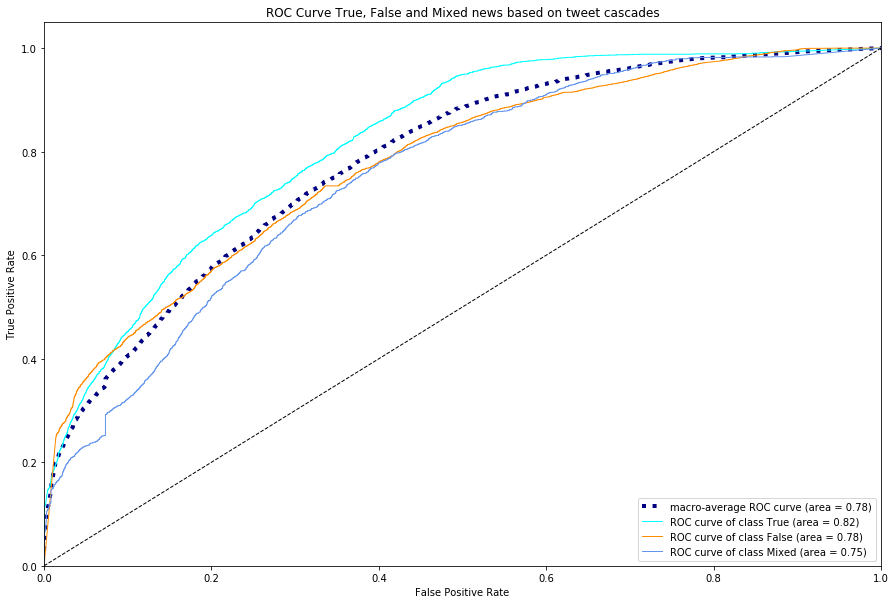

In [35]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_train[:, i], ypred_con[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_train.ravel(), ypred_con.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
n_classes = 3
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot parameters
lw = 1

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr[2], tpr[2], color = 'aqua', lw=lw,
            label='ROC curve of class True (area = {1:0.2f})'
             ''.format(2, roc_auc[2]))
plt.plot(fpr[0], tpr[0], color= 'darkorange', lw=lw,
            label='ROC curve of class False (area = {1:0.2f})'
             ''.format(0, roc_auc[0]))
plt.plot(fpr[1], tpr[1], color= 'cornflowerblue', lw=lw,
            label='ROC curve of class Mixed (area = {1:0.2f})' #check whether coding is correct
             ''.format(1, roc_auc[1]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve True, False and Mixed news based on tweet cascades')
plt.legend(loc="lower right")
plt.show()